# Pairs Trading Strategy

By cheesecakeMafia

## "If we can identify that two assets are co-integrated, we can use that to create arbitrage opportunities through a mean reverting spread"

### In this project, we will run certain statitical tests on the spread of two assets which we hope are correlated and if they pass the statistical test, use a long short strategy to create a spread that will mean revert. 

In [1]:
%%html 
<style>.container{width: 100%} </style>

#### Let's start by making the necessary imports 

In [2]:
#imports
%pylab inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import yfinance as yfin
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as sml
from statsmodels.tsa.api import VECM
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn import linear_model
from scipy import optimize
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

import quantstats as qs

Populating the interactive namespace from numpy and matplotlib


### We will be needing to run certain co-integration tests on the data, we will create some custom functions that we can use later in the code.

#### Customised Functions list

In [3]:
# Function to drop the market column from the dataframe
def drop_market(data):
    data.drop(columns=["S&P 500"],axis=1,inplace=True)
    return data

In [4]:
# Function to plot all securities(columns) individually
def plot_subplots(data,name=" ",ylabel="Price",size=(15,4)):
    y = ylabel
    s = size
    if str(type(data)) == str(pd.core.frame.DataFrame):
        for i in range(len(data.columns)):
            plt.figure(figsize=s)
            plt.xlim(data.index[0],data.index[-1])
            plt.plot(data.index,data.iloc[:,i],label=data.columns[i])
            plt.xlabel(data.index.name)
            plt.ylabel(y)
            plt.legend()
            plt.show();
    else:
        plt.figure(figsize=s)
        plt.xlim(data.index[0],data.index[-1])
        plt.plot(data.index,data.iloc[:],label=name)
        plt.xlabel(data.index.name)
        plt.ylabel(y)
        plt.legend()
        plt.show();
    return None

In [5]:
# Function to plot all columns on a single graph
def plot_aggregate(data):
    data_norm = normalising_data(data)
    data_norm.plot(figsize=(15,6))
    return None

In [6]:
# Function to scale/normalise the data
def normalising_data(data):
    data_norm = data/data.iloc[0]
    return data_norm

In [7]:
# Simple Linear Regression Function(Not used)
def linear_regression(data,endog_col=0):
    """Y is the column index of the endog variable column in data.columns"""    
    y = int(endog_col)
    endog_var = data.iloc[:,y]
    exog_var = data.iloc[:,[x for x in range(len(data.columns)) if x !=y]]
    reg = linear_model.LinearRegression()
    res = reg.fit(exog_var,endog_var)
    return res 

In [8]:
# Vector AutoRegresion Function for Prices (Not spreads as it only takes in positive values)
def VectorAR(data,lags=1,returns=False,summary=False,info_criteria=False):
    if returns==False:
        returns_data = np.log(data).diff().dropna()
    else:
        returns_data = data
    model = VAR(returns_data)
    results = model.fit(lags)
    if info_criteria == False:
        print("-"*50)
        print(" "*25,"Estimate")
        print(results.params, " \n")
        print("-"*50)
        print(" "*25,"SD of Estimate")
        print(results.bse, " \n")
        print("-"*50)
        print(" "*25,"t-Statistic")
        print(results.tvalues, " \n")
        print("-"*50)
    if summary == True:
        print(results.summary())
    return results

In [9]:
# To check optimal lags with AIC and BIC 
def info_criteria(data,lags=10,returns=False):
    n = lags
    if returns==False:
        returns_data = np.log(data).diff().dropna()
    else:
        returns_data = data
    IC = pd.DataFrame([VectorAR(returns_data, lags=p+1,returns=True,info_criteria=True).info_criteria for p in range(n)], index=[p+1 for p in range(n)])
    IC.drop(IC.columns[-2:],axis=1,inplace=True)
    print(IC.to_markdown())
    print(IC.idxmin())
    return None

In [10]:
# Linear Auto Regression(AR model)
def auto_regression(data, lags=1 ,trend="c",summary=False):
    df = pd.DataFrame()
    lag = lags
    t = trend
    model = AutoReg(data,lags = lag, trend = t,missing="drop")
    results = model.fit()
    df = df.append(np.round(results.params,4),ignore_index=True)
    df = df.append(np.round(results.bse,4),ignore_index=True)
    df = df.append(np.round(results.tvalues,4),ignore_index=True)
    df = df.append(np.round(results.pvalues,4),ignore_index=True)
    df.index = ["Estimate","SD of Estimate","t-Statistic","p-values"]
    df = df.T.iloc[::-1]
    print(df.to_markdown())
    if summary == True:
        print(results.summary())
    return results

In [11]:
# Multivariate Linear Regression
def MultiVariate_LR(data,endog_col=0,constant=True,summary=False):
    """Y is the column index of the endog variable column in data.columns"""    
    y = endog_col
    c = constant
    df = pd.DataFrame()
    endog_var = data.iloc[:,y]
    exog_var = data.iloc[:,[x for x in range(len(data.columns)) if x !=y]]
    if c == True:
        exog_var = sm.add_constant(exog_var,prepend=False)
    mod = sm.OLS(endog_var,exog_var,missing='drop')
    reg = mod.fit()
    df = df.append(np.round(reg.params,5),ignore_index=True)
    df = df.append(np.round(reg.bse,5),ignore_index=True)
    df = df.append(np.round(reg.tvalues,5),ignore_index=True)
    df = df.append(np.round(reg.pvalues,5),ignore_index=True)
    df.index = ["Estimate","Std dev","t-Statistic","p-values"]
    df = df.T.iloc[::-1]
    print(df.to_markdown())
    if summary == True:
        print(reg.summary())
    return reg, data.iloc[:,y].name

In [12]:
# Vector Error Correction Model 
def ErrorCorrection(asset,spread,endog_col=0):
    y = endog_col
    df = pd.DataFrame()    
    Y = asset.iloc[:,y]
    X = asset.iloc[:,[x for x in range(len(asset.columns)) if x !=y]]
    del_y = pd.DataFrame(Y).diff().dropna().add_prefix('Δ')
    del_x = pd.DataFrame(X).diff().dropna().add_prefix('Δ')
    correction = del_x.join(spread.shift(1).dropna())
    df1 = del_y.join(correction)
    vecm,name = MultiVariate_LR(df1,endog_col=y,constant=False,summary=False)
    return vecm

In [13]:
# Obtain returns dataframe from a prices dataframe
def returns_data(data,ylabel="percent"):
    y = ylabel
    data_returns = np.log(data).diff().dropna()
    plot_subplots(data_returns,ylabel=y)
    return data_returns

In [14]:
# Describe the data statistically
def describe_securities(data):
    print("Data Stats -->")
    print()
    print(np.round(data.describe().T,4).to_markdown())
    print()  

In [15]:
# Granger Causality test. Code inspired from S Prabhakaran from machinelearningplus.com. Code is modified according to use.
def grangers_causation_matrix(data, variables, maxlag=10,test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [16]:
# Cointegration Test using Johansen procedure. Code inspired from S Prabhakaran from machinelearningplus.com. Code is modified according to use.
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,3)
    d = {'0.9':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)
    print(f'Name   ::  Test Stat > C({(1-alpha)*100}%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
    return out

In [17]:
# Augmented dickey-Fuller Test. Code inspired from S Prabhakaran from machinelearningplus.com. Code is modified according to use. 
def adfuller_test(series,regression="c", signif=0.01, name="", verbose=False):
    reg = regression
    r = adfuller(series,regression=reg, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)
    if name =="" :
        name = series.name
    else :
        pass
    print(f'      Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
    return r

In [18]:
#     Standard Ornstein Uhlenbeck proces which returns dataframe, mean and standard devaition
def OU_process(spread,lags=1,trend="c",summary=False):
    n = lags
    t = trend
    s = summary
    df = pd.DataFrame(columns=["Mean","SD","Half-Life(Days)"],index=["OU Process"])
    a = auto_regression(spread,lags=n,trend=t,summary=s)
    tau = 1/252
    theta = -np.log(a.params[1])/tau
    H = np.log(2)/theta
    days = H/tau
    mean = a.params[0]/(1-a.params[1])
    sigma = ((a.sigma2)/(1-np.exp(-2*theta*tau)))**0.5
    df.iloc[0,0] = np.round(mean,2)
    df.iloc[0,1] = np.round(sigma,2)
    df.iloc[0,2] = int(days+1) if H<2 else "Non significant/Too large" 
    print("")
    print(df.T.to_markdown())
    return df, mean, sigma

### List of custom created functions

1.Drop_market(data) - Drops the S&P 500 market price from the dataframe.

2.plot_subplots(data) - Plot the securities data.

3.normalising_data(data) - Normalising the data by dividing it with the first row.

4.linear_regression(data,engod_col=0) - Running a linear regression on the data.

5.VectorAR(data,n=1,diff=False,summary=False) - Vector Auto Regression.

6.info_criteria(data) - Check for the best AIC and BIC.

7.MultiVariate_LR(data,Y=0,lib="Statsmodels") - Multivariate Linear Regression.

8.ErrorCorrection(data) - Vector Error Correction Model.

9.returns_data(data) - Gets the log returns dataframe from security price dataframe.

10.describe_securities(data) - Describes the dataframe.

11.grangers_causation_matrix(data, variables, maxlag=10,test='ssr_chi2test', verbose=False) - Checks for Grangers-causality.

12.cointegration_test(df, alpha=0.05) - Checks for cointegration between two time series.

13.adfuller_test(series, signif=0.01, name="", verbose=False) - Runs the Augmented Dickey-Fuller Test. 

14.OU_process(spread,lags=1,trend="c",summary=False) - Finds the mean and SD of the spread.

## Selecting the data from yfinance 

In [19]:
# Select the assets on which you want to trade.
def assetclass_selection():
    end =  datetime(2016,10,1).date()  # datetime.now().date()   
    start =  datetime(2010,11,18).date()  #end - pd.Timedelta(days = 365*8) 
    data = pd.DataFrame()
    asset_class = input("You want to trade on which of the following Asset Class - Equity, Commodity or Indices?")
    if asset_class =="Equity":
        print("You have decided to choose Equity.")
        sector = input("Please select the sector you want to trade on, from the following: " +  
                         "Financials, IT or Auto.")
        if sector =="Financials":
            print("You have decided to choose Financials.")
            instruments = ["JPM","C","^GSPC"]
            col = ["JP Morgan","Citi","S&P 500"]
        elif sector == "IT":
            print("You have decided to choose IT.")
            instruments = ["AAPL","MSFT","^GSPC"]
            col = ["Apple","Microsoft","S&P 500"]
        elif sector == "Auto":
            print("You have decided to choose Auto.")
            instruments = ["F","GM","^GSPC"] #"TSLA",
            col = ["Ford","General Motors","S&P 500"] #"Tesla",
        else :
            print("Please enter a valid sector.")
            return    
    elif asset_class == "Commodity":
        print("You have decided to choose Commodity.")
        sector = input("Please select the commodity you want to trade on, from the following:" +  
                         "Oil, Gold or Soybean.")
        if sector =="Oil":
            print("You have decided to choose Oil.")
            instruments = ["CLF22.NYM","CLG22.NYM","^GSPC"] # "CLH22.NYM","CLJ22.NYM"
            col = ["Oil-Jan22","Oil-Feb22","S&P 500"] # "Oil-Mar22","Oil-Apr22"
        elif sector == "Gold":
            print("You have decided to choose Gold.")
            instruments = ["GCG22.CMX","GCJ22.CMX","^GSPC"] #"GCM22.CMX"
            col = ["Gold-Feb22","Gold-Apr22","S&P 500"] # "Gold-Jun22"
        elif sector == "Soybean":
            print("You have decided to choose Soybean.")
            instruments = ["ZSF22.CBT","ZSH22.CBT","^GSPC"] # "ZSK22.CBT"
            col = ["Soybean-Jan22","Soybean-Mar22","S&P 500"] # "Soybean-May22"
        else :
            print("Please enter a valid commodity.")
            return    
    elif asset_class == "Indices":
        print("You have decided to choose Indices.")
        sector = input("Please select the Index future you want to trade on, from the following:" +  
                         "S&P 500, Dow Jones or Nikkei.")
        if sector =="S&P 500":
            print("You have decided to choose S&P 500 Index.")
            instruments = ["ESZ21.CME","ESH22.CME","^GSPC"] # "ESM22.CME","ESU22.CME"
            col = ["E-mini-Dec21","E-mini-Mar22","S&P 500"] # "E-mini-Jun22","E-mini-Sep22"
        elif sector == "Dow Jones":
            print("You have decided to choose Dow Jones Index.")
            instruments = ["YMZ21.CBT","YMH22.CBT","^GSPC"] # "YMM22.CBT"
            col = ["DJI-Dec21","DJI-Mar22","S&P 500"] # "DJI-Jun22"
        elif sector == "Nikkei":
            print("You have decided to choose Nikkei 225 Index.")            
            instruments = ["NKDZ21.CME","NKDM22.CME","^GSPC"] # ,"NKDM23.CME"
            col = ["NI225-Dec21","NI225-Mar21","S&P 500"] # "NI225-Jun21"
        else :
            print("Please enter a valid Index.")          
    else :
        print("Please enter a valid asset class.")
        instruments = []

    for asset in instruments:
        prices = yfin.download(asset,start,end,auto_adjust=True)
        data[asset] = prices["Close"]        
    data.columns = col
    data.dropna(inplace=True) # Cleaning the data. Dropping rows containing null values.
    data = data.round(4)
    return data, data[data.columns[-1]]   

### Choose assets you want to trade on. Used Ford and GM for illustration purpose. Market returns are assumed to be similar to S&P 500's returns.

In [20]:
securities, market = assetclass_selection()

You want to trade on which of the following Asset Class - Equity, Commodity or Indices?Equity
You have decided to choose Equity.
Please select the sector you want to trade on, from the following: Financials, IT or Auto.Auto
You have decided to choose Auto.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [21]:
securities.head()

,Ford,General Motors,S&P 500
Date,,,
2010-11-18,10.8726,26.4252,1196.6899
2010-11-19,10.9805,26.4793,1199.7300
2010-11-22,10.9265,26.3402,1197.8400
2010-11-23,10.5893,25.6987,1180.7300
2010-11-24,10.7579,25.8765,1198.3500


#### If you want to use custom data of two assets please use the following commented out cell to enter the data

In [22]:
# securities = 

#### We could see the basic statistics of the assets we chose to trade on.

In [23]:
describe_securities(securities)

Data Stats -->

|                |   count |      mean |      std |       min |       25% |       50% |       75% |       max |
|:---------------|--------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|
| Ford           |    1477 |    9.977  |   1.7308 |    6.0933 |    8.7555 |   10.4092 |   11.3077 |   12.783  |
| General Motors |    1477 |   24.4637 |   4.2993 |   14.5304 |   21.4478 |   25.7264 |   27.5946 |   32.0983 |
| S&P 500        |    1477 | 1700.52   | 329.085  | 1099.23   | 1362.21   | 1751.64   | 2023.57   | 2190.15   |



#### Plot the assets individually.

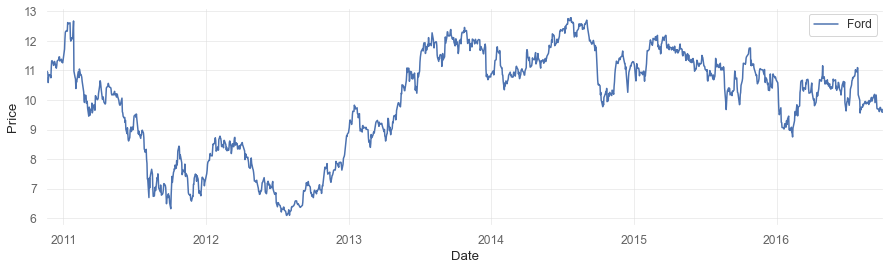

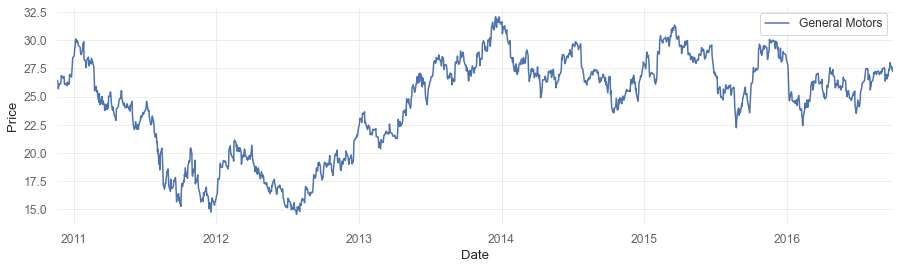

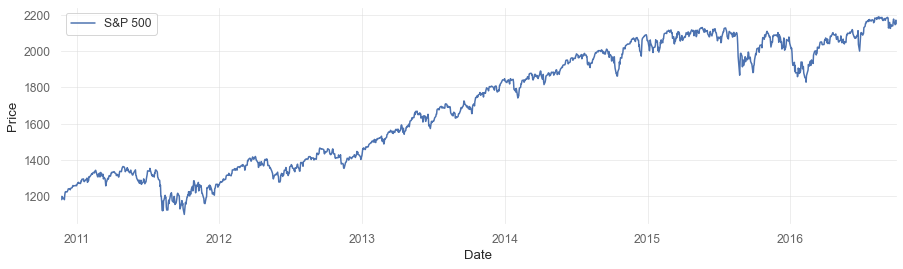

In [24]:
plot_subplots(securities)

#### Plot them in a single graph after normalising the assets by dividing by first observation.

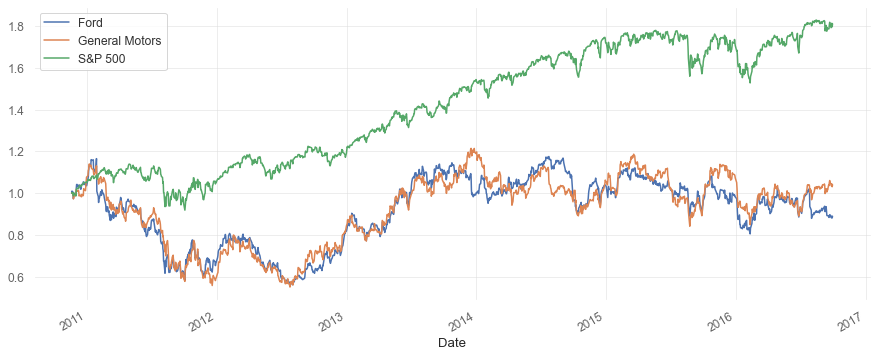

In [25]:
plot_aggregate(securities)

#### Define a new data frame called ret which contains the daily returns of the prices available in the securities data frame. 

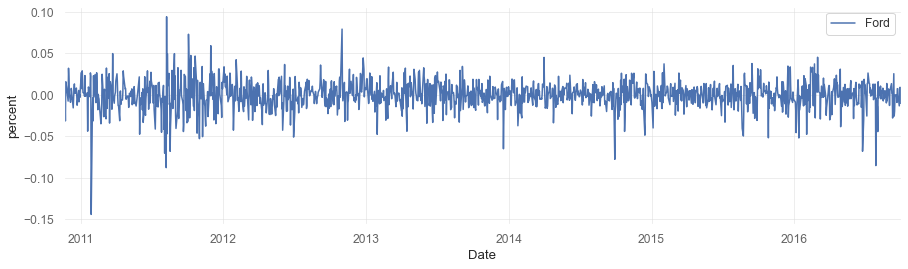

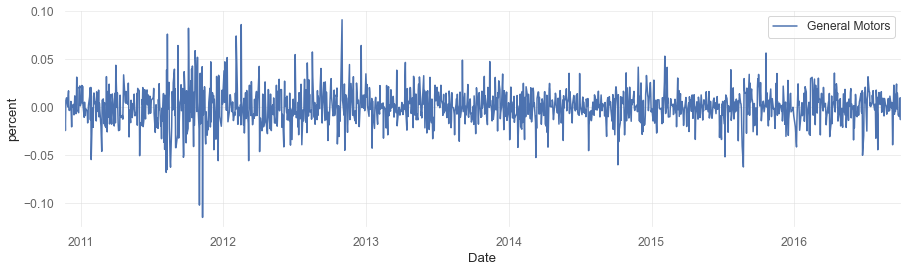

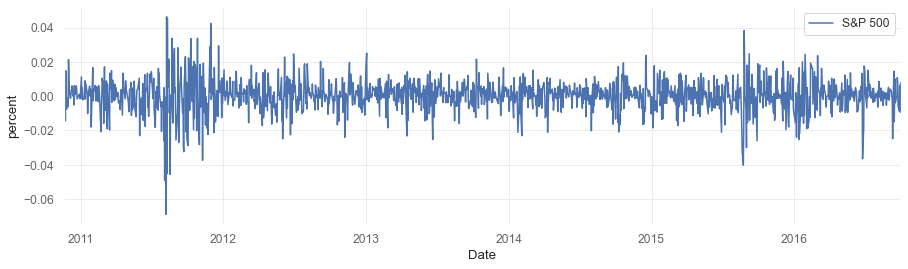

In [26]:
ret = returns_data(securities)

In [27]:
securities = drop_market(securities)

#### To prove that running regression on returns is a bad idea, we run auto regression on the ret data frame. 

In [28]:
v = VectorAR(ret,returns=True,summary=False)

--------------------------------------------------
                          Estimate
                       Ford  General Motors   S&P 500
const             -0.000041        0.000034  0.000427
L1.Ford            0.104155        0.060934  0.006391
L1.General Motors -0.003923       -0.017089  0.004116
L1.S&P 500        -0.092148       -0.007019 -0.063438  

--------------------------------------------------
                          SD of Estimate
                       Ford  General Motors   S&P 500
const              0.000447        0.000481  0.000251
L1.Ford            0.041472        0.044557  0.023252
L1.General Motors  0.036660        0.039387  0.020554
L1.S&P 500         0.068089        0.073155  0.038175  

--------------------------------------------------
                          t-Statistic
                       Ford  General Motors   S&P 500
const             -0.091728        0.070268  1.702177
L1.Ford            2.511464        1.367549  0.274860
L1.General Motors -0.1070

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


#### We find that p-values are not significant even at the 5% interval level and hence this is a bad idea.

In [29]:
v.pvalues<0.05

,Ford,General Motors,S&P 500
const,False,False,False
L1.Ford,True,False,False
L1.General Motors,False,False,False
L1.S&P 500,False,False,False


In [30]:
v.info_criteria

{'aic': -26.903854795714103,
 'bic': -26.860765331832553,
 'hqic': -26.887788904551538,
 'fpe': 2.0692088995544574e-12}

In [31]:
info_criteria(ret,10,returns=True)

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

|    |      aic |      bic |
|---:|---------:|---------:|
|  1 | -26.9039 | -26.8608 |
|  2 | -26.895  | -26.8196 |
|  3 | -26.8975 | -26.7896 |
|  4 | -26.8926 | -26.7523 |
|  5 | -26.8992 | -26.7265 |
|  6 | -26.8874 | -26.6822 |
|  7 | -26.8788 | -26.641  |
|  8 | -26.8709 | -26.6006 |
|  9 | -26.868  | -26.565  |
| 10 | -26.8568 | -26.5212 |
aic    1
bic    1
dtype: int64


C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


## Cointegration Analysis

### We will now run cointegration analysis on the pair of securities and see if their spread is stationary.

#### First we'll take the residual of Ford with respect to General Motors

In [32]:
eg1, name1 = MultiVariate_LR(securities,0,1)

|                |   Estimate |   Std dev |   t-Statistic |   p-values |
|:---------------|-----------:|----------:|--------------:|-----------:|
| const          |    0.72745 |   0.08942 |       8.13515 |          0 |
| General Motors |    0.37809 |   0.0036  |     105.023   |          0 |


In [33]:
beta = eg1.params[0]
beta

0.37809211506946827

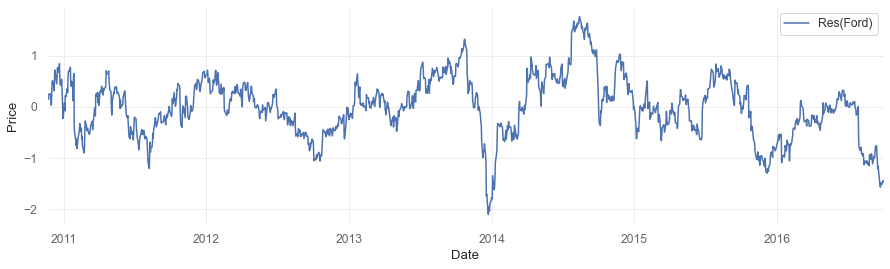

In [34]:
e = eg1.resid
plot_subplots(e,name=f"Res({name1})")

In [35]:
e.name = f"Res({name1})"

In [36]:
adf = adfuller_test(e,regression="c",signif=0.01,name = e.name,verbose=True)

      Augmented Dickey-Fuller Test on "Res(Ford)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.01
 Test Statistic        = -3.7604
 No. Lags Chosen       = 0
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0033. Rejecting Null Hypothesis.
 => Series is Stationary.


### We find that the spread is stationary after running Augmented Dickey Fuller test. Hence, we could conclude that these stocks are cointegrated and make a good pair to trade on.

#### Now, we will do it the other way around and take the residual of General Motors with respect to Ford

In [37]:
eg2, name2 = MultiVariate_LR(securities,1,1)

|       |   Estimate |   Std dev |   t-Statistic |   p-values |
|:------|-----------:|----------:|--------------:|-----------:|
| const |    1.18856 |   0.22493 |       5.28419 |          0 |
| Ford  |    2.33288 |   0.02221 |     105.023   |          0 |


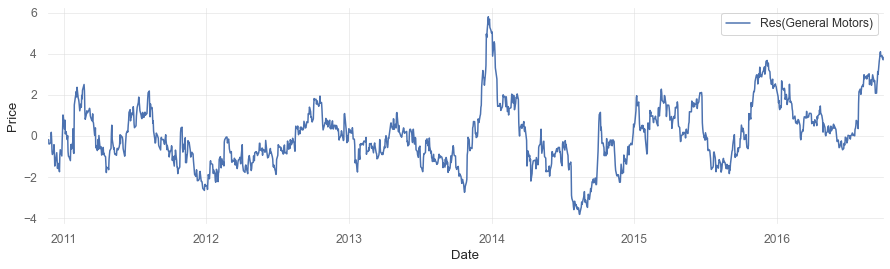

In [38]:
e2 = eg2.resid
plot_subplots(e2,name=f"Res({name2})")

In [39]:
e2.name = f"Res({name2})"

In [40]:
adf2 = adfuller_test(e2,regression="c",name=e2.name)

      Augmented Dickey-Fuller Test on "Res(General Motors)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.01
 Test Statistic        = -3.7535
 No. Lags Chosen       = 0
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0034. Rejecting Null Hypothesis.
 => Series is Stationary.


#### Although we see that both the stocks are great to trade on, we still run Vector Error Correction Model and check whether it has any significance.

#### We will do it on both the spreads and check if the p-values are significant or not.

In [41]:
eg3 = ErrorCorrection(securities,e,0)

|                 |   Estimate |   Std dev |   t-Statistic |   p-values |
|:----------------|-----------:|----------:|--------------:|-----------:|
| ΔGeneral Motors |    0.27261 |   0.00736 |      37.0202  |    0       |
| Res(Ford)       |   -0.01596 |   0.00521 |      -3.06444 |    0.00222 |


In [42]:
eg4 = ErrorCorrection(securities,e2,0)

|                     |   Estimate |   Std dev |   t-Statistic |   p-values |
|:--------------------|-----------:|----------:|--------------:|-----------:|
| ΔGeneral Motors     |    0.27264 |   0.00738 |      36.9591  |    0       |
| Res(General Motors) |    0.0055  |   0.0021  |       2.61987 |    0.00889 |


In [43]:
eg3.pvalues<0.05

ΔGeneral Motors    True
Res(Ford)          True
dtype: bool

In [44]:
eg4.pvalues<0.05

ΔGeneral Motors        True
Res(General Motors)    True
dtype: bool

## Now we will fit the model in the Ornstein Uhlenbeck process to find the mean, standard deviation and Half life of the spread

In [45]:
ou ,meu, sigma = OU_process(e,1)

|              |   Estimate |   SD of Estimate |   t-Statistic |   p-values |
|:-------------|-----------:|-----------------:|--------------:|-----------:|
| intercept    |    -0.0011 |           0.0033 |       -0.3261 |     0.7443 |
| Res(Ford).L1 |     0.9791 |           0.0055 |      176.702  |     0      |

|                 |   OU Process |
|:----------------|-------------:|
| Mean            |        -0.05 |
| SD              |         0.62 |
| Half-Life(Days) |        33    |


C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [46]:
t = [0.5,1,1.5,1.75,2,2.25,2.5,3]

In [47]:
Z_value = pd.DataFrame(np.zeros((8,2)),columns=["+Z","-Z"],index = [f'Z_{x}' for x in t])    

In [48]:
for i in range(8):
    for j in range(2):
        if j%2 == 0:
            k = float(Z_value.index[i].split("_")[-1]) 
            Z_value.iloc[i,j] = meu+(k*sigma)
        else:
            Z_value.iloc[i,j] = meu-(k*sigma) 
    Z_value.iloc[i,j] = np.round(Z_value.iloc[i,j],4)


In [49]:
Z_value

,+Z,-Z
Z_0.5,0.259426,-0.3622
Z_1,0.570263,-0.6731
Z_1.5,0.881099,-0.9839
Z_1.75,1.036518,-1.1393
Z_2,1.191936,-1.2948
Z_2.25,1.347354,-1.4502
Z_2.5,1.502772,-1.6056
Z_3,1.813609,-1.9164


### We define another data frame Z_1 for values when Z=0.5 and import Upper and Lower boundaries from Z_value data frame.

In [50]:
Z_1 = pd.DataFrame(np.zeros((e.shape[0],3)),index = e.index, columns=["Upper boundary","Lower boundary","Position"]).join(e)

In [51]:
Z_1.iloc[:,0] = Z_value.iloc[0,0] # To get Z_x just use this --> Z_x.iloc[:,0] = Z_value.iloc[position of x in Z_value,0]
Z_1.iloc[:,1] = Z_value.iloc[0,1] # # To get Z_x just use this --> Z_x.iloc[:,0] = Z_value.iloc[position of x in Z_value,1]
# Z_1

### Now, we define the position/signal based on the spread position with respect to upper and lower bounds.

In [52]:
for i in range(len(Z_1.index)):
    if Z_1.iloc[i,-1]>Z_1.iloc[i,0]:
        Z_1.iloc[i,-2] = int(-1)
    elif Z_1.iloc[i,-1]<Z_1.iloc[i,1]:
        Z_1.iloc[i,-2] = int(1)
    else:
        Z_1.iloc[i,-2] = int(0)

In [53]:
for i in range(1,len(Z_1.index)):
    if (Z_1.iloc[i-1,-2] == -1) & (Z_1.iloc[i,-1]>meu):
        Z_1.iloc[i,-2] = int(-1)
    elif (Z_1.iloc[i-1,-2] == -1) & (Z_1.iloc[i,-1]<meu):
        Z_1.iloc[i,-2] = int(0)
    elif (Z_1.iloc[i-1,-2] == 1) & (Z_1.iloc[i,-1]<meu):
        Z_1.iloc[i,-2] = int(1)
    elif (Z_1.iloc[i-1,-2] == 1) & (Z_1.iloc[i,-1]>meu):
        Z_1.iloc[i,-2] = 0
            
Z_1    

,Upper boundary,Lower boundary,Position,Res(Ford)
Date,,,,
2010-11-18,0.259426,-0.3622,0.0,0.153992
2010-11-19,0.259426,-0.3622,0.0,0.241437
2010-11-22,0.259426,-0.3622,0.0,0.240030
2010-11-23,0.259426,-0.3622,0.0,0.145376
2010-11-24,0.259426,-0.3622,0.0,0.246751
...,...,...,...,...
2016-09-26,0.259426,-0.3622,1.0,-1.516595
2016-09-27,0.259426,-0.3622,1.0,-1.475148
2016-09-28,0.259426,-0.3622,1.0,-1.485200


### We use the Z_1["Position"] column and use it to further manipulate the securities data frame and further add two extra columns called returns and position.

In [54]:
securities["Signal"] = Z_1["Position"]

In [55]:
# securities

In [56]:
securities["returns"] = np.zeros((securities.shape[0],1))

In [57]:
securities["Position"] = "NaN"

In [58]:
for i in range(1,len(securities.index)):
    if (securities.iloc[i-1,2] == 0) & (securities.iloc[i,2] == 0):
        securities.iloc[i,-1] = "NaN"
    elif (securities.iloc[i-1,2] == 0) & (securities.iloc[i,2] == -1):
        securities.iloc[i,-1] = "Short on spread"
    elif (securities.iloc[i-1,2] == 0) & (securities.iloc[i,2] == 1):
        securities.iloc[i,-1] = "Long on spread"
    elif (securities.iloc[i-1,2] == -1) & (securities.iloc[i,2] == 0):
        securities.iloc[i,-1] = "Close short"
    elif (securities.iloc[i-1,2] == -1) & (securities.iloc[i,2] == -1):
        securities.iloc[i,-1] = "Short position held"
    elif (securities.iloc[i-1,2] == 1) & (securities.iloc[i,2] == 0):
        securities.iloc[i,-1] = "Close long"
    elif (securities.iloc[i-1,2] == 1) & (securities.iloc[i,2] == 1):
        securities.iloc[i,-1] = "Lond position held"
    else:
        securities.iloc[i,-1] = "NaN"
        

In [59]:
a1,a2,b1,b2 = 0,0,0,0
for i in range(len(securities.index)):
    if securities.iloc[i,-1] == "Short on spread":
        a1 = securities.iloc[i,0]
        b1 = beta*securities.iloc[i,1]
    elif securities.iloc[i,-1] == "Close short":
        a2 = securities.iloc[i,0]
        b2 = beta*securities.iloc[i,1]
        securities.iloc[i,-2] = (b2/b1) - (a2/a1) 
        a1,a2,b1,b2 = 0,0,0,0
    elif securities.iloc[i,-1] == "Long on spread":
        a1 = securities.iloc[i,0]
        b1 = beta*securities.iloc[i,1]
    elif securities.iloc[i,-1] == "Close long":
        a2 = securities.iloc[i,0]
        b2 = beta*securities.iloc[i,1]
        securities.iloc[i,-2] = (a2/a1) - (b2/b1)
        a1,a2,b1,b2 = 0,0,0,0

In [60]:
securities["Cum Returns"] = np.ones((len(securities.index),1))

In [61]:
for i in range(1,len(securities.index)):
    if securities.iloc[i,3] != 0:
        securities.iloc[i,-1] = securities.iloc[i-1,-1]*(1+securities.iloc[i,3])
    else:
        securities.iloc[i,-1] = securities.iloc[i-1,-1]
    
securities

,Ford,General Motors,Signal,returns,Position,Cum Returns
Date,,,,,,
2010-11-18,10.8726,26.4252,0.0,0.0,NaN,1.000000
2010-11-19,10.9805,26.4793,0.0,0.0,NaN,1.000000
2010-11-22,10.9265,26.3402,0.0,0.0,NaN,1.000000
2010-11-23,10.5893,25.6987,0.0,0.0,NaN,1.000000
2010-11-24,10.7579,25.8765,0.0,0.0,NaN,1.000000
...,...,...,...,...,...,...
2016-09-26,9.6147,27.5167,1.0,0.0,Lond position held,4.778262
2016-09-27,9.5907,27.3436,1.0,0.0,Lond position held,4.778262
2016-09-28,9.6788,27.6032,1.0,0.0,Lond position held,4.778262


In [66]:
securities.to_excel("C:\\Users\\Admin\\Downloads\\timepass.xlsx")

## We now use the quantstats library and check the various backtesting metrics of the strategy and see how the results fare when compared to S&P 500.

In [62]:
qs.extend_pandas()

In [63]:
market1 = market.pct_change()

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2010-11-18  2010-11-18
End Period                 2016-09-30  2016-09-30
Risk-Free Rate             0.0%        0.0%
Time in Market             3.0%        100.0%

Cumulative Return          377.83%     81.19%
CAGR%                      30.53%      10.65%

Sharpe                     2.21        0.74
Sortino                    inf         1.04
Sortino/√2                 inf         0.74

Max Drawdown               nan%        -19.39%
Longest DD Days            -           -
Volatility (ann.)          12.43%      15.23%
R^2                        0.0         0.0
Calmar                     inf         0.55
Skew                       7.86        -0.41
Kurtosis                   66.53       4.45

Expected Daily %           0.11%       0.04%
Expected Monthly %         2.23%       0.84%
Expected Yearly %          25.04%      8.86%
Kelly Criterion            nan%      

None

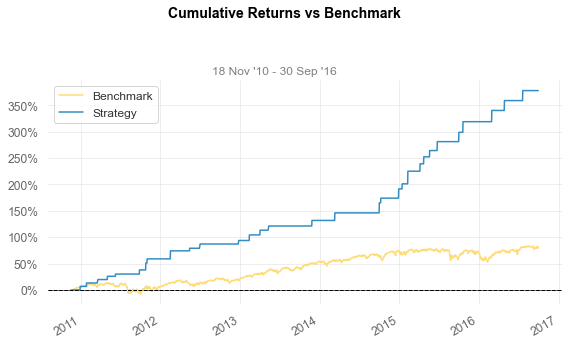

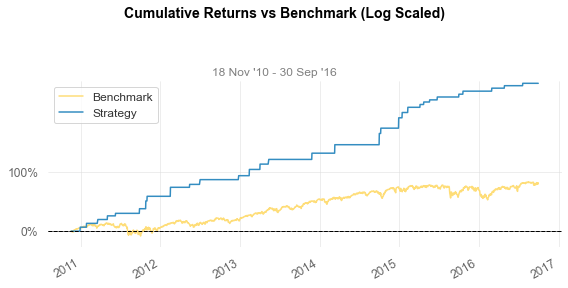

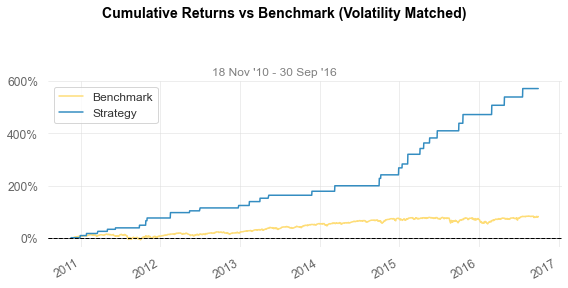

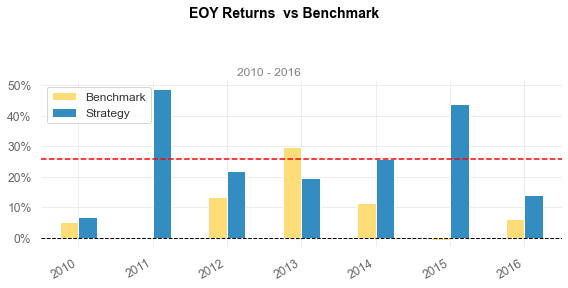

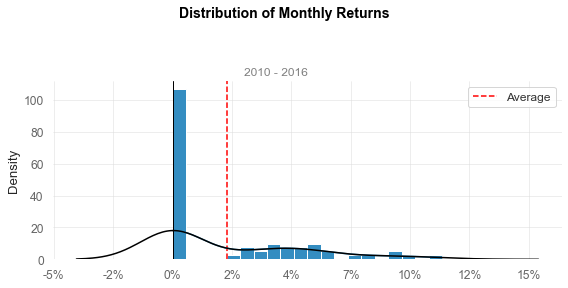

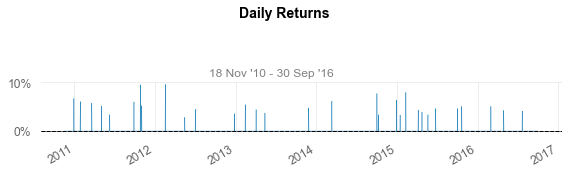

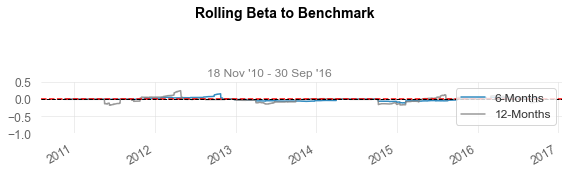

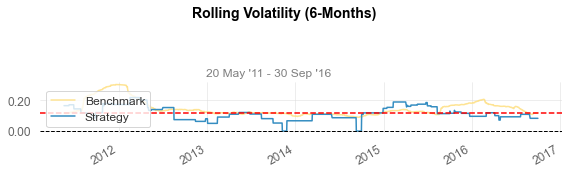

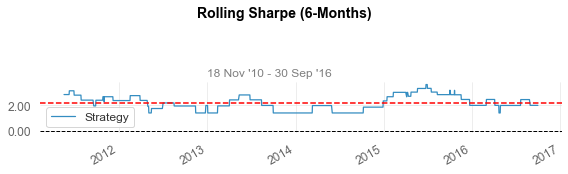

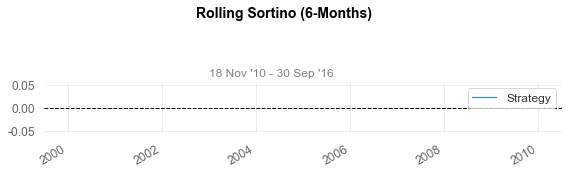

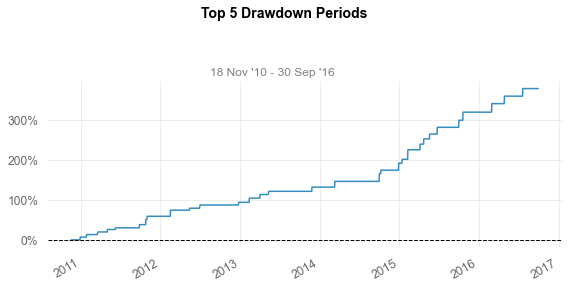

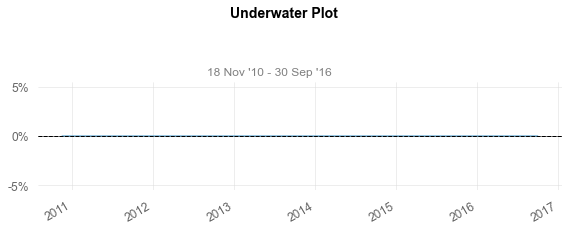

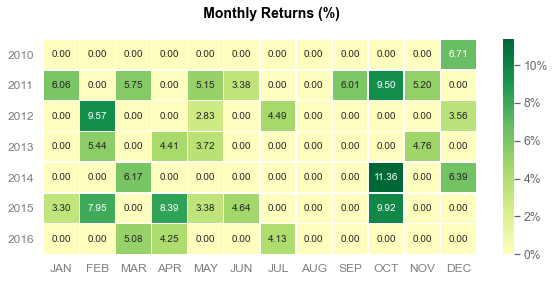

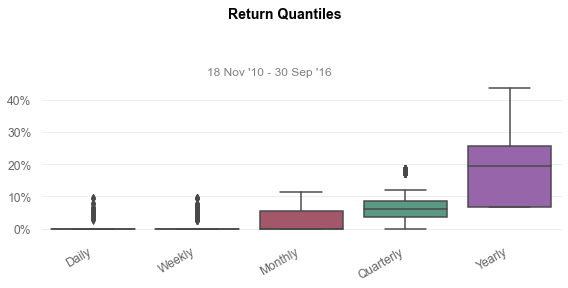

In [64]:
qs.reports.full(securities["returns"],benchmark=market1)

## Here we see that we have not put any stop loss. But it would be a cardinal sin to think that we will never take a loss given that we will never exit on a loss as we might blow up our account given that the co-integration might break down and the spread between the two securities might not be stationary or even mean revert.  

In [65]:
# qs.reports.html(securities["returns"],benchmark=market1,output="C:\\Users\Admin\Downloads\qwert.html")